# <div style="text-align:center;">**Capuchin Bird Signal Processing**</div>

# 1. Load Dependencies

Since I am using a venv, I am installing the required packages using pip. For some reason tf.audio.decode_wav does not work with tensorflow 2.14.0. I couldn't install tensorflow 2.8.0 from python 3.11 so I am using python 3.8.6 to install the following dependencies.

In [133]:
"""%pip install matplotlib
%pip install tensorflow==2.8.0
%pip install tensorflow_io==0.24.0"""

'%pip install matplotlib\n%pip install tensorflow==2.8.0\n%pip install tensorflow_io==0.24.0'

Furthermore, to be able to import tensorflow 2.8.0, the photobuf plugin needs to be downgraded to a version < 3.20. 

In [134]:
"""%pip install protobuf==3.20"""

'%pip install protobuf==3.20'

In [135]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import sys

In [136]:
print('tensorflow version:', tf.__version__)
print('tensorflow_io version:', tfio.__version__)
print(sys.version)

tensorflow version: 2.8.0
tensorflow_io version: 0.24.0
3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]


Lets export the dependencies used in a txt file.

In [137]:
"""%pip freeze > requirements.txt"""

'%pip freeze > requirements.txt'

# 2. Data Collection

In [138]:
def load_data(file):
    try:
        # get the file extension of the file
        _, file_extension = os.path.splitext(file)
        if file_extension.lower() == '.mp3':
            # Read and decode the MP3 file
            res = tfio.audio.AudioIOTensor(file)
            wav = res.to_tensor()
            wav = tf.math.reduce_sum(wav, axis=1)/2
            sample_rate = res.rate
            sample_rate = tf.cast(sample_rate, dtype=tf.int64)
                
        elif file_extension.lower() == '.wav':
            # Read and decode the WAV file
            wav, sample_rate = tf.audio.decode_wav(tf.io.read_file(file), desired_channels=1)
            wav = tf.squeeze(wav, axis=-1)

    except TypeError: # bypass error when using map(spectrogram)
        print('mapping error bypassed')
        wav, sample_rate = tf.audio.decode_wav(tf.io.read_file(file), desired_channels=1)
        wav = tf.squeeze(wav, axis=-1)

    sample_rate = tf.cast(sample_rate, dtype=tf.int64)    
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

    return wav

## 3. EDA

Lets use random library to sample some files from each of the folders and see what their respecitve waveforms look like.

A wavegform is essentially a time series plot with the signal amplitude at each instance.

In [139]:
from IPython import display
import random
import collections
random.seed(42) # pass a seed for reproducibility

In [140]:
# sample from the capuchin files
capu_folder_path = 'data/Parsed_Capuchinbird_Clips'
capu_files = os.listdir(capu_folder_path)
capu_sampled = random.sample(capu_files, 4)

display.display(display.Audio(load_data(os.path.join('data', 'Parsed_Capuchinbird_Clips', capu_sampled[0])), rate=16000))

In [141]:
# sample from the non-capuchin files
non_capu_folder_path = 'data/Parsed_Not_Capuchinbird_Clips'
non_capu_files = os.listdir(non_capu_folder_path)
non_capu_sampled = random.sample(non_capu_files, 4)

display.display(display.Audio(load_data(os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', non_capu_sampled[0])), rate=16000))

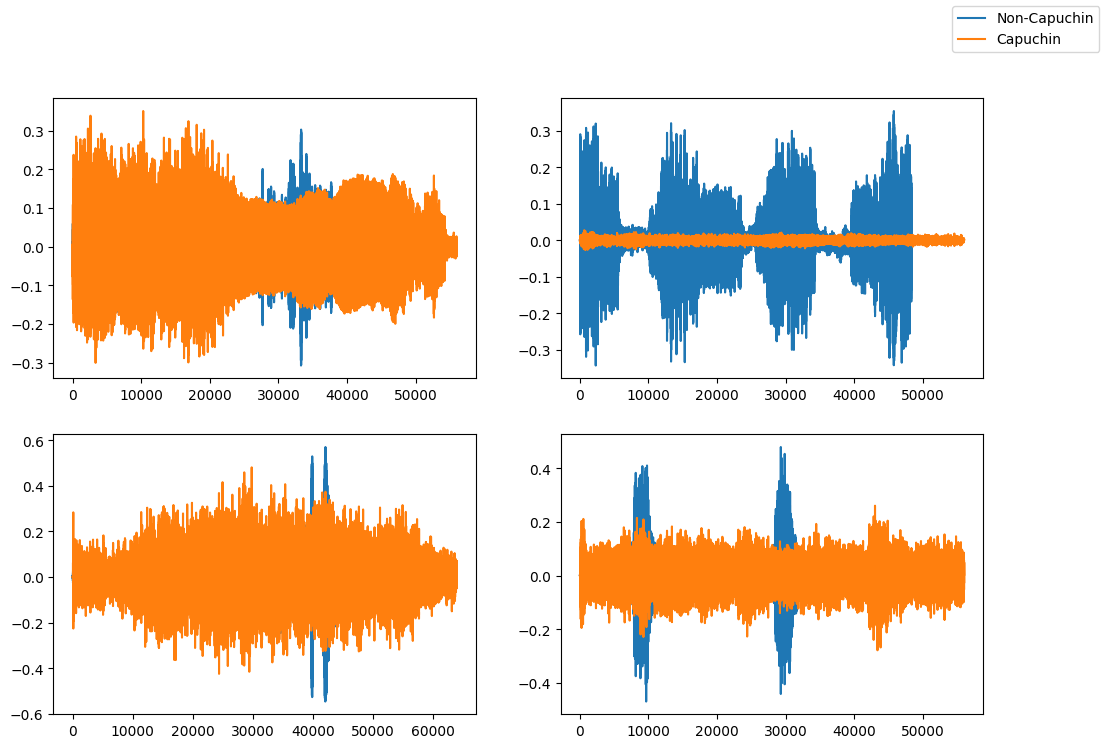

In [142]:
# plot the waveforms
fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    ax[i//2, i%2].plot(load_data(os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', non_capu_sampled[i])))
    ax[i//2, i%2].plot(load_data(os.path.join('data', 'Parsed_Capuchinbird_Clips', capu_sampled[i])))
fig.legend(['Non-Capuchin', 'Capuchin'], loc='upper right')

## Average waveform length

In [143]:
capu_length = []
for file in os.listdir(capu_folder_path):
    capu_length.append(len(load_data(os.path.join(capu_folder_path, file))))

print(collections.Counter(capu_length))
print(len(capu_length))

Counter({56000: 255, 48000: 174, 64000: 129, 40000: 51, 72000: 15, 32000: 12, 55999: 9, 39999: 3, 80000: 3})
651


Counter({48160: 55, 48304: 49, 48640: 39, 48031: 38, 48559: 28, 49295: 19, 48175: 19, 48560: 19, 48928: 16, 48768: 16, 48703: 14, 48783: 14, 49311: 13, 48655: 13, 49072: 12, 48320: 11, 49056: 11, 48032: 10, 48912: 9, 50111: 9, 50880: 9, 49696: 9, 49055: 8, 50431: 8, 50127: 7, 49071: 7, 48191: 7, 48911: 6, 52079: 5, 50895: 5, 49712: 5, 49695: 5, 51503: 5, 48927: 4, 52080: 4, 53360: 4, 48576: 4, 48767: 4, 48144: 3, 50112: 3, 49711: 3, 49312: 3, 53823: 3, 48176: 3, 50128: 2, 51279: 2, 55472: 2, 54591: 2, 48687: 2, 53359: 2, 51567: 2, 51551: 2, 50432: 2, 58080: 2, 48192: 2, 48575: 2, 56207: 2, 51488: 2, 51295: 1, 51296: 1, 55471: 1, 55456: 1, 54607: 1, 52064: 1, 52063: 1, 53807: 1, 53808: 1, 54047: 1, 54048: 1, 54032: 1, 60735: 1, 60720: 1, 60719: 1, 53375: 1, 51568: 1, 56192: 1, 56191: 1, 61423: 1, 63087: 1, 51487: 1, 52863: 1, 52847: 1, 47229: 1, 49040: 1, 49039: 1})
tf.Tensor(29233161, shape=(), dtype=int32)


Text(0.5, 0, 'waveform length*16k')

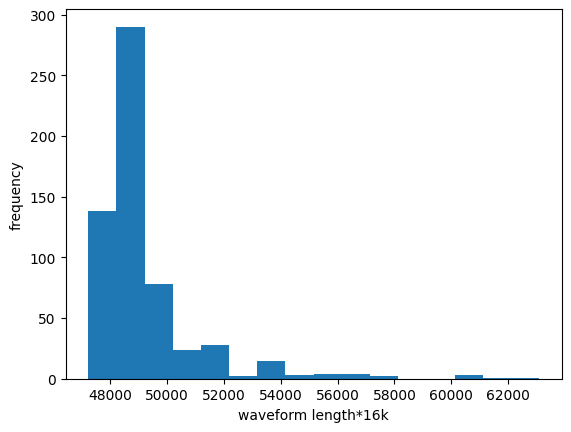

In [144]:
non_capu_length = []
for file in os.listdir(non_capu_folder_path):
    non_capu_length.append(len(load_data(os.path.join(non_capu_folder_path, file))))

print(collections.Counter(non_capu_length))
print(tf.math.reduce_sum(non_capu_length))
plt.hist(non_capu_length, bins=16)
plt.ylabel('frequency')
plt.xlabel('waveform length*16k')

## Observations

### 1. There is a class imbalance with capu:non_capu = 1:3. 
Solution: We can fix this issue by oversampling our capuchin bird sounds.
### 2. The lengths of the recordings vary significantly
Solution: Most of the waveform lengths at least 3 seconds (48000 data points after sampling at 16000Hz). We can therefore cut all wavelengths to this length and use zero padding for the ones that are shorter than that

# 4. Preprocessing

## Oversampling

We can generate 2 more eqully sized capuchin training sets by using librosa library and slighly modifying the pitch of the capuchin bird recordings.

In [145]:
"""%pip install librosa"""

'%pip install librosa'

In [146]:
import librosa

In [147]:
def pitch_amplification(wav, pitch_shift_factor):
    wav_shifted = librosa.effects.pitch_shift(wav.numpy(), sr=16000, n_steps=pitch_shift_factor)
    return wav_shifted

In [148]:
wav_orig = load_data(os.path.join('data', 'Parsed_Capuchinbird_Clips', capu_sampled[0]))
wav_low = pitch_amplification(wav_orig, -2)
wav_high = pitch_amplification(wav_orig, 2)

# lets hear the output from the different transforms
print('original sound')
display.display(display.Audio(wav_orig, rate=16000))
print('low pitch modified sound')
display.display(display.Audio(wav_low, rate=16000))
print('high pitch modified sound')
display.display(display.Audio(wav_high, rate=16000))

original sound


low pitch modified sound


high pitch modified sound


Generate the new sounds and save them under Parsed_Capuchinbird_Clips

In [149]:
def save_wav(wav, file_path, sample_rate=16000):
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    encoded_wav = tf.audio.encode_wav(wav, sample_rate=sample_rate)
    tf.io.write_file(file_path, encoded_wav)

In [150]:
"""for file in os.listdir(capu_folder_path):
    # load the waveforms
    wav = load_data(os.path.join(capu_folder_path, file))
    # apply the 2 transforms
    wav_low, wav_high = pitch_amplification(wav, -2), pitch_amplification(wav, 2)
    # expand dimension to reverse the effect of squeezing
    wav_low, wav_high = tf.expand_dims(wav_low, axis=-1), tf.expand_dims(wav_high, axis=-1)
    # define the new file names
    file_name_low = file[:-4]+'_low_pitch_trfm.wav'
    file_name_high = file[:-4]+'_high_pitch_trfm.wav'
    # save to folder
    save_wav(wav_low, os.path.join(capu_folder_path, file_name_low), sample_rate=16000)
    save_wav(wav_high, os.path.join(capu_folder_path, file_name_high), sample_rate=16000)"""

"for file in os.listdir(capu_folder_path):\n    # load the waveforms\n    wav = load_data(os.path.join(capu_folder_path, file))\n    # apply the 2 transforms\n    wav_low, wav_high = pitch_amplification(wav, -2), pitch_amplification(wav, 2)\n    # expand dimension to reverse the effect of squeezing\n    wav_low, wav_high = tf.expand_dims(wav_low, axis=-1), tf.expand_dims(wav_high, axis=-1)\n    # define the new file names\n    file_name_low = file[:-4]+'_low_pitch_trfm.wav'\n    file_name_high = file[:-4]+'_high_pitch_trfm.wav'\n    # save to folder\n    save_wav(wav_low, os.path.join(capu_folder_path, file_name_low), sample_rate=16000)\n    save_wav(wav_high, os.path.join(capu_folder_path, file_name_high), sample_rate=16000)"

# 5. Data preprocessing

In [151]:
# labell the files
positives = tf.data.Dataset.zip((tf.data.Dataset.list_files(capu_folder_path+'\*.wav'), tf.data.Dataset.from_tensor_slices(tf.ones(len(capu_length)))))
negatives = tf.data.Dataset.zip((tf.data.Dataset.list_files(non_capu_folder_path+'\*.wav'), tf.data.Dataset.from_tensor_slices(tf.zeros(len(non_capu_length)))))
data = positives.concatenate(negatives)

In [152]:
# check that the labelling has been done
print(positives.as_numpy_iterator().next())
print(negatives.as_numpy_iterator().next())

(b'data\\Parsed_Capuchinbird_Clips\\XC201990-1_high_pitch_trfm.wav', 1.0)
(b'data\\Parsed_Not_Capuchinbird_Clips\\sparrow-sound-effect-46.wav', 0.0)


In [153]:
def wav_trimming(wav):
    # trim to 3 seconds
    wav = wav[:48000]
    # zero pad lengths less than 3 seconds
    wav = tf.concat([tf.zeros([48000]- tf.shape(wav), dtype=tf.float32), wav], 0)
    return wav

In [154]:
def spectrogram_convert(file_path, label):
    wav = load_data(file_path)
    wav = wav_trimming(wav)
    # apply short-time Fourier transform
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [155]:
data.as_numpy_iterator().next()

(b'data\\Parsed_Capuchinbird_Clips\\XC178168-4.wav', 1.0)

In [156]:
data = data.map(spectrogram_convert)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(25)
data = data.prefetch(8)

pass


In [157]:
train = data.take(36)
test = data.skip(36).take(14)

# 6. Modelling the CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Activation, MaxPooling2D

In [ ]:
kernel_size = (3,3)
print(data.as_numpy_iterator().next()[0].shape)

(25, 1491, 257, 1)


In [ ]:
feature_layers = [
    Conv2D(25, kernel_size, activation='relu', input_shape=(1491,257,1)),
    Conv2D(15, kernel_size, activation='sigmoid'),
    MaxPooling2D(3),
    Dropout(0.1),
    Flatten(),
]

In [ ]:
classification_layers = [
    Dense(128),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid')
]

In [ ]:
model = Sequential(feature_layers+classification_layers)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 25)     250       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 15)     3390      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 495, 84, 15)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 495, 84, 15)       0         
                                                                 
 flatten (Flatten)           (None, 623700)            0         
                                                                 
 dense (Dense)               (None, 128)               79833728  
                                                        

In [ ]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
history = model.fit(train, epochs=6, validation_data=test, verbose=1)

Epoch 1/6


36/36 [==============================] - 605s 15s/step - loss: 45.8436 - recall: 0.5498 - precision: 0.5638 - val_loss: 6.6205 - val_recall: 1.0000 - val_precision: 0.5320
Epoch 2/6
36/36 [==============================] - 591s 16s/step - loss: 4.1359 - recall: 0.7173 - precision: 0.7158 - val_loss: 2.9605 - val_recall: 1.0000 - val_precision: 0.5733
Epoch 3/6
36/36 [==============================] - 607s 17s/step - loss: 1.4315 - recall: 0.8721 - precision: 0.8542 - val_loss: 0.5826 - val_recall: 0.8922 - val_precision: 0.9255
Epoch 4/6
36/36 [==============================] - 591s 16s/step - loss: 1.0558 - recall: 0.8994 - precision: 0.8955 - val_loss: 0.9303 - val_recall: 1.0000 - val_precision: 0.7617
Epoch 5/6
36/36 [==============================] - 563s 15s/step - loss: 1.0069 - recall: 0.9021 - precision: 0.9021 - val_loss: 0.2020 - val_recall: 0.9545 - val_precision: 0.9711
Epoch 6/6
36/36 [==============================] - 506s 14s/step - loss: 0.5060 - recall: 0.9104 - preci

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 25)     250       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 15)     3390      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 495, 84, 15)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 495, 84, 15)       0         
                                                                 
 flatten (Flatten)           (None, 623700)            0         
                                                                 
 dense (Dense)               (None, 128)               79833728  
                                                        

In [ ]:
import pickle

In [ ]:
# Serialize the model architecture to JSON
model_json = model.to_json()

# Save the JSON to a file using pickle
with open('model1.pkl', 'wb') as file:
    pickle.dump(model_json, file)

NameError: name 'model' is not defined